# multiphase/interFoam/laminar/mixerVessel2D


In [12]:
%matplotlib inline
import numpy as np
from vtk.util.numpy_support import vtk_to_numpy
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import vtk
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [13]:
def plotPolar(nodes, a, vmin=0, vmax=0):
    color_map = plt.cm.get_cmap('seismic')
    ax = plt.subplot(111, projection='polar')
    print"Shapes: {} {} {}".format(nodes[:,0].shape, nodes[:,1].shape, a.shape)
    ax.plot(nodes[:,0], nodes[:,1], 
            color=a, 
            cmap = color_map)
    ax.set_rmax(2.0)
    ax.grid(True)

    ax.set_title("A line plot on a polar axis", va='bottom')
    plt.show()

In [29]:
import os
files = os.listdir("mixerVessel2D/VTK")
for f in files:
    print(f)

back
front
mixerVessel2D_0.vtk
mixerVessel2D_101.vtk
mixerVessel2D_117.vtk
mixerVessel2D_133.vtk
mixerVessel2D_149.vtk
mixerVessel2D_164.vtk
mixerVessel2D_179.vtk
mixerVessel2D_194.vtk
mixerVessel2D_209.vtk
mixerVessel2D_224.vtk
mixerVessel2D_238.vtk
mixerVessel2D_251.vtk
mixerVessel2D_264.vtk
mixerVessel2D_276.vtk
mixerVessel2D_28.vtk
mixerVessel2D_288.vtk
mixerVessel2D_299.vtk
mixerVessel2D_310.vtk
mixerVessel2D_320.vtk
mixerVessel2D_330.vtk
mixerVessel2D_340.vtk
mixerVessel2D_350.vtk
mixerVessel2D_359.vtk
mixerVessel2D_368.vtk
mixerVessel2D_377.vtk
mixerVessel2D_386.vtk
mixerVessel2D_395.vtk
mixerVessel2D_404.vtk
mixerVessel2D_414.vtk
mixerVessel2D_424.vtk
mixerVessel2D_434.vtk
mixerVessel2D_444.vtk
mixerVessel2D_454.vtk
mixerVessel2D_464.vtk
mixerVessel2D_47.vtk
mixerVessel2D_473.vtk
mixerVessel2D_482.vtk
mixerVessel2D_491.vtk
mixerVessel2D_500.vtk
mixerVessel2D_66.vtk
mixerVessel2D_84.vtk
rotor
stator


In [30]:
def plot3D(nodes, a, vmin=0, vmax=0):
    print"Shapes: {} {} {}".format(nodes[:,0].shape, nodes[:,1].shape, a.shape)
    color_map = plt.cm.get_cmap('plasma')
    fig = plt.figure(figsize=(14,10))
    ax = fig.add_subplot(111, projection='3d')
    if vmax==0 and vmin==0:
        vmin = np.amin(a)
        vmax = np.amax(a)
    splt = ax.scatter(nodes[:,0],nodes[:,1],nodes[:,2],s=60,
                   c = a,
                   cmap = color_map,
                   vmin = vmin,
                   vmax = vmax,
                   marker='o')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    fig.colorbar(splt, shrink=0.5)
    plt.show()

In [31]:
def getData(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    vtk_arrays= reader.GetOutput().GetPointData()
    #print vtk_nodes
    #print vtk_arrays
    return vtk_arrays

def getNodes(filename):
    # load a vtk file as input
    reader = vtk.vtkUnstructuredGridReader()
    reader.SetFileName(filename)
    reader.Update()
    #print reader.GetOutput().GetPoints()
    # Get the coordinates of nodes in the mesh
    nodes_vtk_array= reader.GetOutput().GetPoints().GetData()  
    nodes = vtk_to_numpy(nodes_vtk_array)
    return nodes

In [32]:
# Remove data for z != 0
def extractFlatData(nodes, a, U):
    merged = np.empty([len(nodes),6])
    merged[:,0] = a
    merged[:,1:3] = U[:,:2]
    merged[:,3:] = nodes
    # Merged z0 and z1 arrays should be same because of 
    # the model symmetry along z-axis
    merged_z0 = merged[np.where(merged[:,5] == 0)]
    merged_z1 = merged[np.where(merged[:,5] != 0)]
    # Extract nodes, p and U arrays from z0 array
    a = merged_z0[:,0]
    U = merged_z0[:,1:3]
    nodes = merged_z0[:,3:5]
    return nodes, a, U

def plot2D(nodes, a, vmin, vmax):     
    # 2d plotting
    fig = plt.figure(figsize=(8,6))
    cmap = mpl.cm.seismic
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-.1,2.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(nodes[:,0],nodes[:,1],
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    fig.tight_layout()

In [127]:
def plotVector(X, Y, UN, VN, U, vmin, vmax, filename=""):
    plot1 = plt.figure(figsize=(14,10))
    print U.shape
    stride_elmts = 10
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    Usub = U[::stride_elmts]
    print Usub.shape
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data
               Usub,                   # colour the arrows based on this array
               #cmap=plt.cm.plasma,     # colour map
               #norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax), # Colour range fix
               
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity vector')
    if (filename != ""):
        plot1.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show(plot1)                 # display the plot
    plt.close(plot1)

In [131]:
def plotCombined(X, Y, UN, VN, U, vmin, vmax, a, filename=""):
    plot1 = plt.figure(figsize=(14,10))
    
    print a.shape    
    color_map = plt.cm.get_cmap('plasma')
    axes = plt.gca()
    #axes.set_xlim([-.1,2.1])
    #axes.set_ylim([-.01,0.11])
    #plt.axis('off')
    sc = plt.scatter(X,Y,
                     s=320,
#                     color=cmap(a / a_max),
                     c = a,
                     cmap = color_map,
                     vmin = vmin,
                     vmax = vmax,
                     linewidth=0, 
                     marker="s")
    plt.colorbar(sc)
    #fig.tight_layout()
    print U.shape
    stride_elmts = 10
    Xsub = X[::stride_elmts]
    Ysub = Y[::stride_elmts]
    UNsub= UN[::stride_elmts]
    VNsub= VN[::stride_elmts]
    Usub = U[::stride_elmts]
    print Usub.shape
    plt.quiver(Xsub, Ysub, UNsub, VNsub,        # data
               Usub,                   # colour the arrows based on this array
               #cmap=plt.cm.plasma,     # colour map
               #norm=mpl.colors.Normalize(vmin=vmin,vmax=vmax), # Colour range fix               
               scale=10
               )

    plt.colorbar()                  # adds the colour bar
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Velocity vector')
    
    
    
    if (filename != ""):
        plot1.tight_layout()
        plt.savefig(filename,bbox_inches='tight')
    else:
        plt.show(plot1)                 # display the plot
    plt.close(plot1)



In [132]:
filename = "mixerVessel2D/VTK/mixerVessel2D_0.vtk"
#nodes, p , U   = getData_pvm(filename)
vtk_data = getData(filename)
nodes = getNodes(filename)
#print nodes
p = vtk_to_numpy(vtk_data.GetArray(0))
#print p
alpha = vtk_to_numpy(vtk_data.GetArray(1))
#print alpha
p_rgh = vtk_to_numpy(vtk_data.GetArray(2))
U = vtk_to_numpy(vtk_data.GetArray(3))
a = alpha

vmin = np.nanmin(a)
vmax = np.nanmax(a)
print "{} - {}".format(vmin,vmax)
print a.shape



0.0 - 1.0
(6528,)


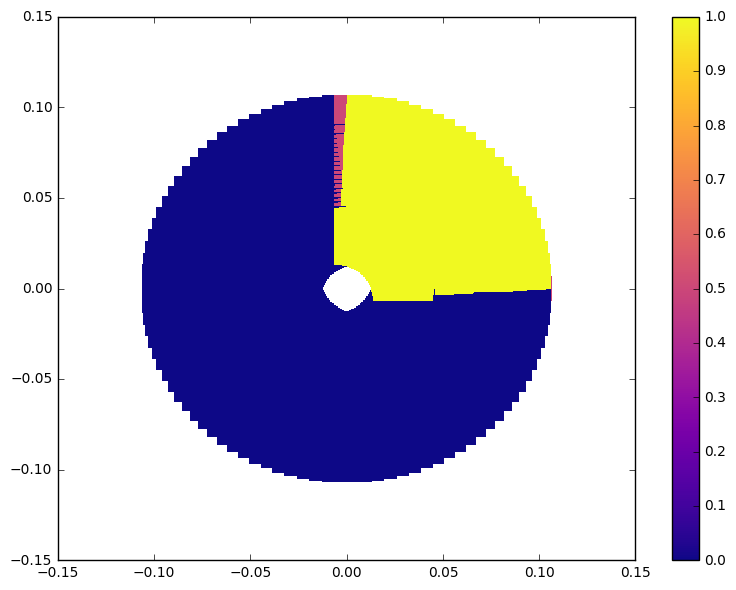

In [133]:
nodes_half, a_half, U_half = extractFlatData(nodes, a, U)
plot2D(nodes_half,a_half, vmin, vmax)

Shapes: (6528,) (6528,) (6528,)


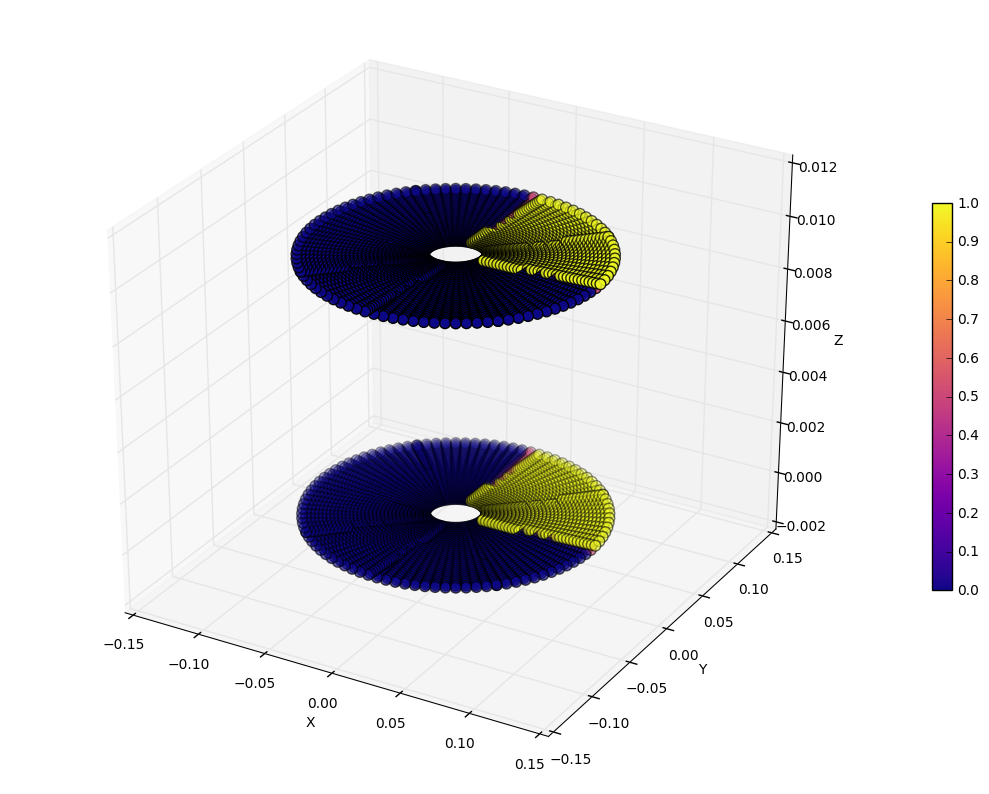

In [134]:
R = nodes[:,0]
P = nodes[:,1]

plot3D(nodes, a, vmin, vmax)
#plotPolar(nodes, a, vmin, vmax)

(0.0, 0.0)
(3264,)
(327,)


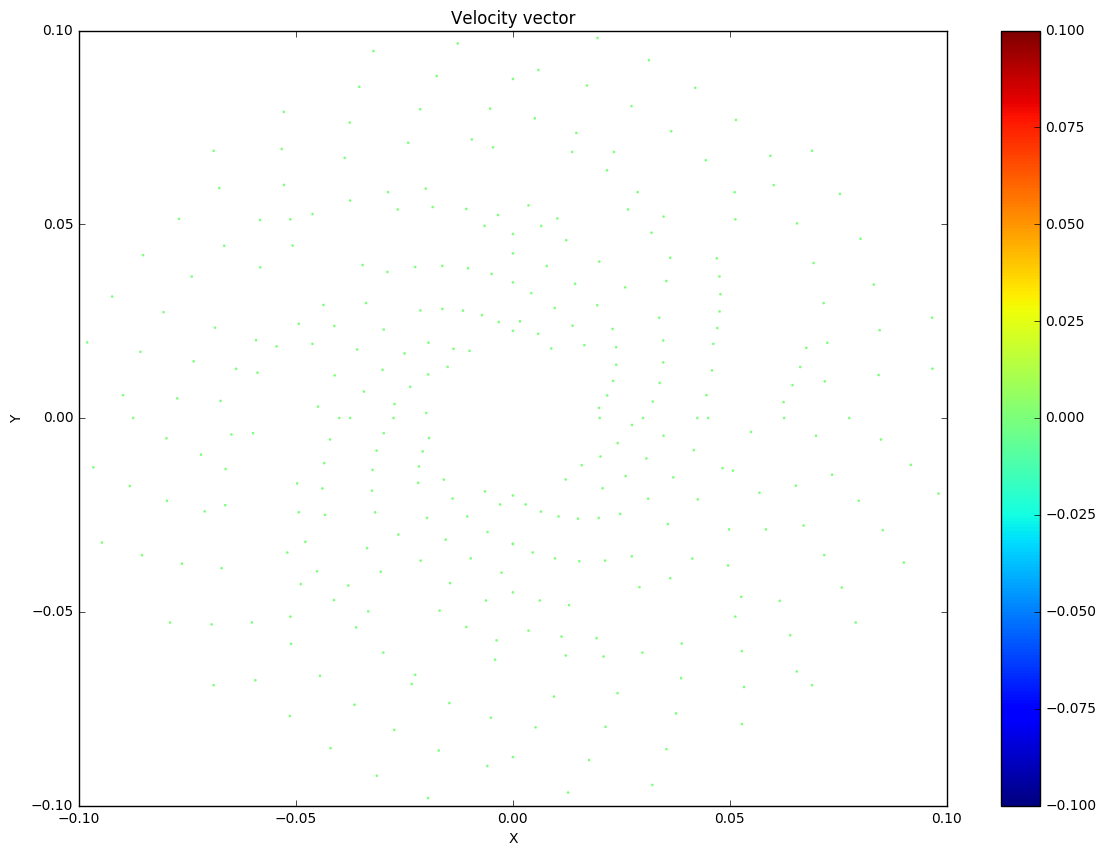

In [135]:
Un_half = np.sqrt(U_half[:,0]**2 + U_half[:,1]**2) #Randomisation:  + np.random.rand(U_half.shape[0])
print(np.amin(Un_half),np.amax(Un_half))
plotVector(nodes_half[:,0], nodes_half[:,1], U_half[:,0], U_half[:,1], 
               Un_half, np.amin(Un_half), np.amax(Un_half))

Un half: 0.0 - 0.0
[ 0.  0.  0. ...,  1.  1.  1.]
(3264,)
(3264,)
(327,)


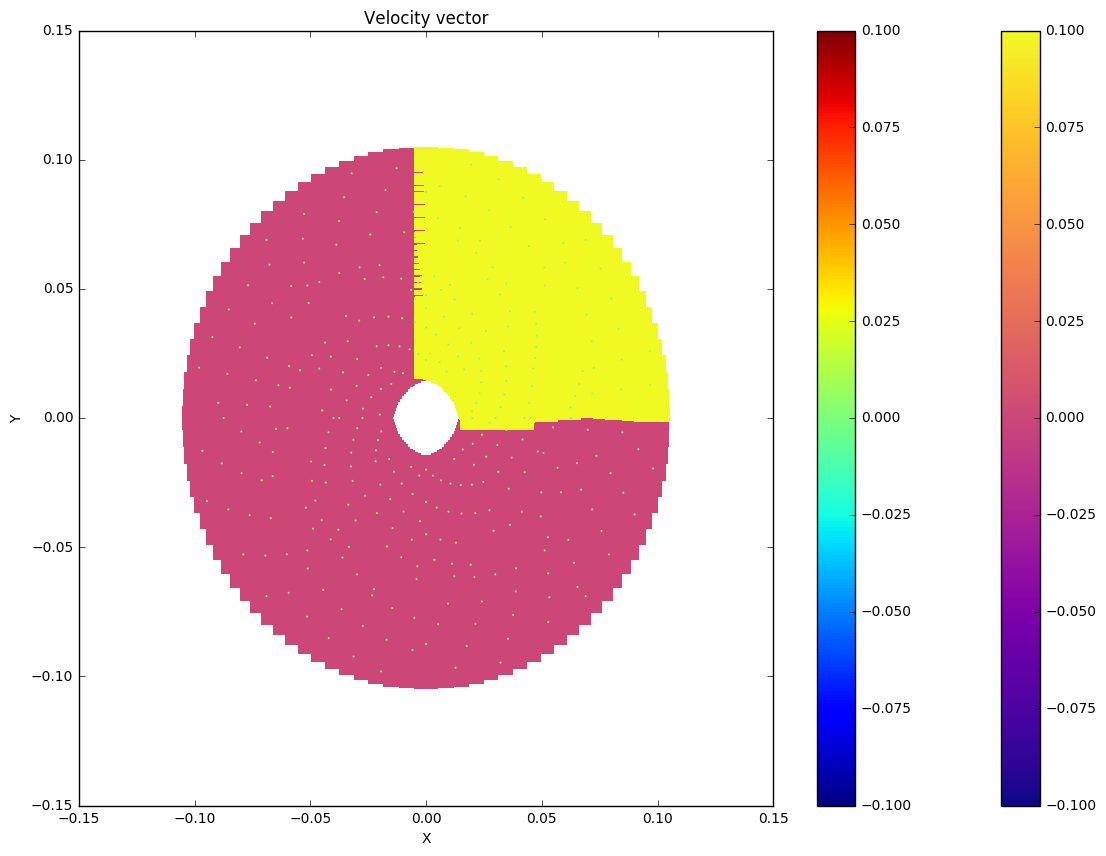

In [136]:
Un_half = np.sqrt(U_half[:,0]**2 + U_half[:,1]**2) #Randomisation:  + np.random.rand(U_half.shape[0])
print"Un half: {} - {}".format(np.amin(Un_half),np.amax(Un_half))
print a
plotCombined(nodes_half[:,0], nodes_half[:,1], U_half[:,0], U_half[:,1], 
               Un_half, np.amin(Un_half), np.amax(Un_half), a_half)